# Overview

1. Load model and dataset
  1. Data was saved to Google Drive and loaded to Google Colab
2. Validate baseline model
  1. Baseline model was loaded and sklearn pipeline explored
  2. Predictions were created for sanity checking
3. Explore training dataset
  1. Reviewed training shape and features
  2. Correlation heatmap created
  3. Plots for each feature created
4. Train / Validate new model
  1. All work performed in PyCharm
5. Modify flask api for predictions
  1. Docker container created

Note: Comparing the ratio of paid/claim it appears that there are three groups of payments. These three groups may be due to a hidden variable or may have been artificially constructed. If they were artifically constructed a possible method could have followed this process:
1. randomly assign a small subset of claims to a near zero payment group
2. randomly assign the remaining claims to group I or group II
3. create two linears models with gaussian noise, one for group I and one for group II, and generate claim payment amounts for each claim using the model for each group
4. introduce additional noise by randomly setting claim payment amount to a negative value or some positive value.



## 0. Set up compute environment
1. Mount Google Drive
2. Load standard libraries
3. Create plotting functions

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Import model libraries
from sklearn import set_config
from sklearn.metrics import r2_score

In [ ]:
# Create reusable plotting functions
def plot_scatter_box(x, y):
  plt.subplots(figsize=(10, 5))

  plt.subplot(1, 2, 1) # row 1, column 2, item 1
  plt.scatter(x=x, y=y)
  plt.title('Scatterplot')
  plt.xlabel(x.name)
  plt.ylabel(y.name)
  plt.text(50, 5000, f'$R^2$ Value = {baseline_r_squared:.2%}')

  plt.subplot(1, 2, 2)
  plt.title('Boxplot')
  pd.concat([x, y], axis=1).boxplot() 

  plt.tight_layout(4)

  plt.show()


def plot_frequency_histogram(x):
  x.value_counts().plot(kind='bar')
  plt.title(x.name)
  plt.show()

## 1. Load model and dataset

In [ ]:
# Import the existing serialized model, ignore sklearn verison warnings
import warnings
warnings.simplefilter('ignore', UserWarning)
baseline_model = joblib.load('/content/drive/MyDrive/healthcare-startup/model.joblib')

In [ ]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/healthcare-startup/train.zip', index_col='claim_id')
df.head()

,claim_amount,drg,is_medicaid,is_medicare,npi,paid_amount,patient_age,payer_name
claim_id,,,,,,,,
edec6a2f-f49e-4db3-8828-2e7f44d48864,1040.13,24,False,True,8000148798,676.08,51,zxiVJcrvbPtJtXlX
3992ef78-1fcb-4423-8d9e-a0fbeb753053,1165.98,64,False,True,1557768496,749.60,41,ZqHRFBrwwWIvGXIp
22495465-9522-4d0f-8b11-398622205dd8,4123.75,10,False,True,6353925914,2592.41,56,ZqHRFBrwwWIvGXIp
64f4edc9-c3d8-4b60-9861-2e1561602685,1298.27,75,False,True,1600962387,896.91,41,zAvkCGVqMOcnuzBM
6bb3c092-fd41-4e5d-a3c1-cc4949cd4543,738.64,45,False,False,2158735615,492.09,77,wJNWQFLnvvgztLpN


## 2. Validate baseline model

1. Generate predictions from dataset
2. Plot actual to predict results

In [ ]:
# Visualize the baseline model
set_config(display='diagram')
baseline_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['drg', 'npi', 'payer_name',
                                                   'is_medicaid',
                                                   'is_medicare']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['claim_amount',
                                                   'patient_age'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# Confirm model can predict on dataset
results = pd.DataFrame({'actual': df['paid_amount'],
                        'baseline_predicted': baseline_model.predict(df)})

baseline_r_squared = r2_score(results['actual'], results['baseline_predicted'])

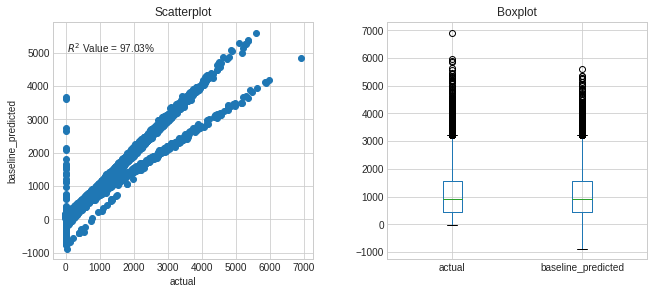

In [ ]:
# Plot actual and baseline predicted for visual comparison
plot_scatter_box(x=results['actual'], y=results['baseline_predicted'])

## 3. Explore training dataset

Some of the sample training data is likely non-randomly sampled from a population (equal claims by payer) but the claim amounts are assumed to be a random sample from the population.

Paid vs Claim scatter plot shows three groups: people who pay zero, people who pay almost exactly as billed, and people who pay around 65% of billed.

Feature notes:
* claim_id: assume this can only be used as a unique index, no meaningful predictive information
* claim_amount: highly right skewed, positive data
* patient_age: normally distributed data
* is_medicaid: boolean, highly unbalanced
* is_medicare: boolean, highly unbalanced, negatively correlated with medicaid
* drg: contains a largest group that dominates sample
* npi: two providers dominate sample
* payer_name: equally distributed
* paid_amount: target variable, highly correlated with claim amount

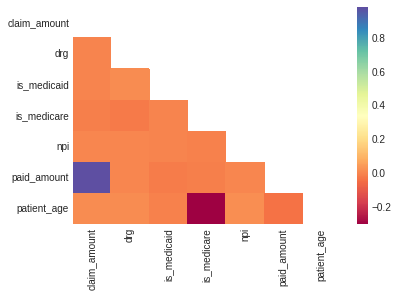

In [ ]:
# Create a lower triangular correlation heatmap
corr_df =  df.corr(method='pearson') 
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral");

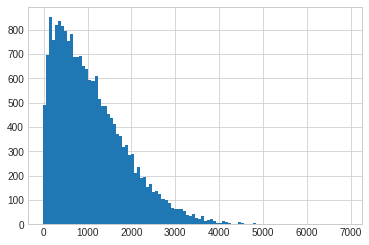

In [ ]:
# In classic statistics this would be a good candidate for gamma regression
df['paid_amount'].hist(bins=100);

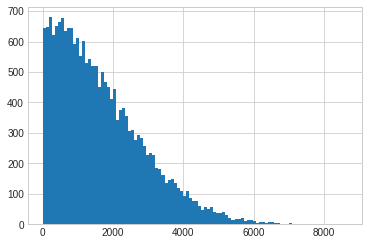

In [ ]:
# Claim amount will obviously be highly correlated with paid amount
df['claim_amount'].hist(bins=100);

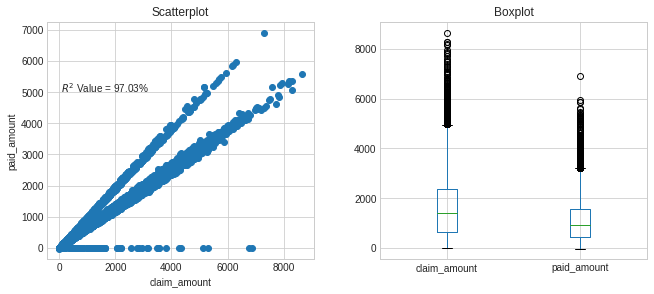

In [ ]:
# Compare claim amount to paid amount
plot_scatter_box(x=df['claim_amount'], y=df['paid_amount'])

In [ ]:
pct_paid_lteq_claim = (df['paid_amount'] <= df['claim_amount']).mean()
pct_paid_zero = (df['paid_amount'] == 0).mean()
pct_claim_zero = (df['claim_amount'] == 0).mean()

print(f'Claim equal to zero {pct_claim_zero:.2%}.')
print(f'Paid equal to zero {pct_paid_zero:.2%}.')
print(f'Paid less than or equal to claim: {pct_paid_lteq_claim:.2%}.')

Claim equal to zero 0.00%.
Paid equal to zero 0.41%.
Paid less than or equal to claim: 100.00%.


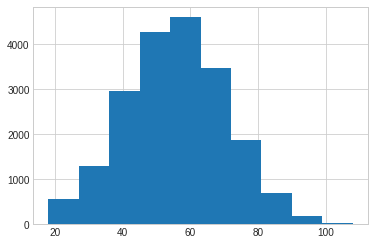

In [ ]:
# Quite the normal distribution here
df['patient_age'].hist();

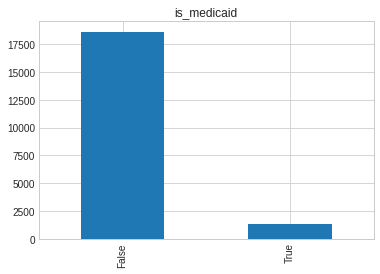

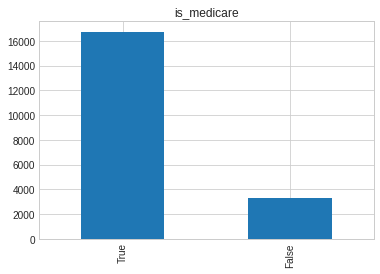

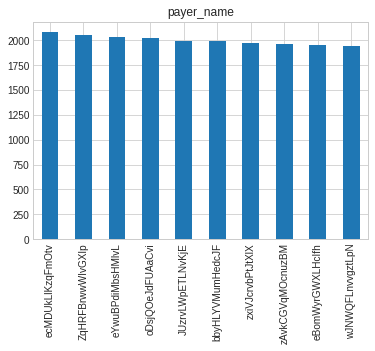

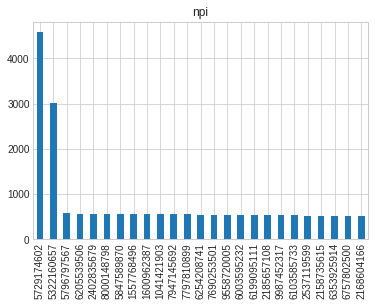

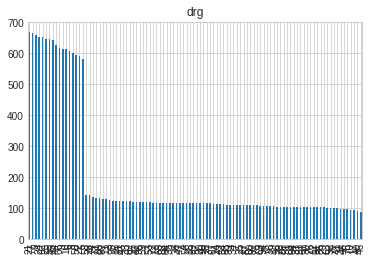

In [ ]:
# View histogram of discrete value counts
discrete_cols = ['is_medicaid', 'is_medicare', 'payer_name', 'npi', 'drg']
for col in discrete_cols:
  plot_frequency_histogram(df[col])

## 4. Train / Validate new model

Training was performed in PyCharm with the python module `trainer.py`

## 5. Modify flask api for predictions

A simple Docker container was created to run a flask app.